# 1. Introuction

This notebook outlines the creation, compilation, and training of a Data Efficient Image Transformer (DeiT) network to classify 101 types of food.

# 2. Importing Libraries

In [1]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd

from torch import nn
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
from timm import create_model
#from warmup_scheduler_pytorch import WarmUpScheduler
#from timm.scheduler.cosine_lr import CosineLRScheduler

# Import custom libraries
from modules.helper_functions import set_seeds, display_random_images
from modules.engine import Trainer, sec_to_min_sec
from modules.scheduler import FixedLRSchedulerWrapper
from modules.dataloaders import create_dataloaders
#from modules.scheduler import WarmupCosineAnnealingLR

# Define some constants
NUM_WORKERS = os.cpu_count()
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

# 3. Specifying Target Device

In [2]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Sun Jan 19 13:06:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   46C    P0             25W /  200W |    1304MiB /  12282MiB |      2%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 4. Image Visualization

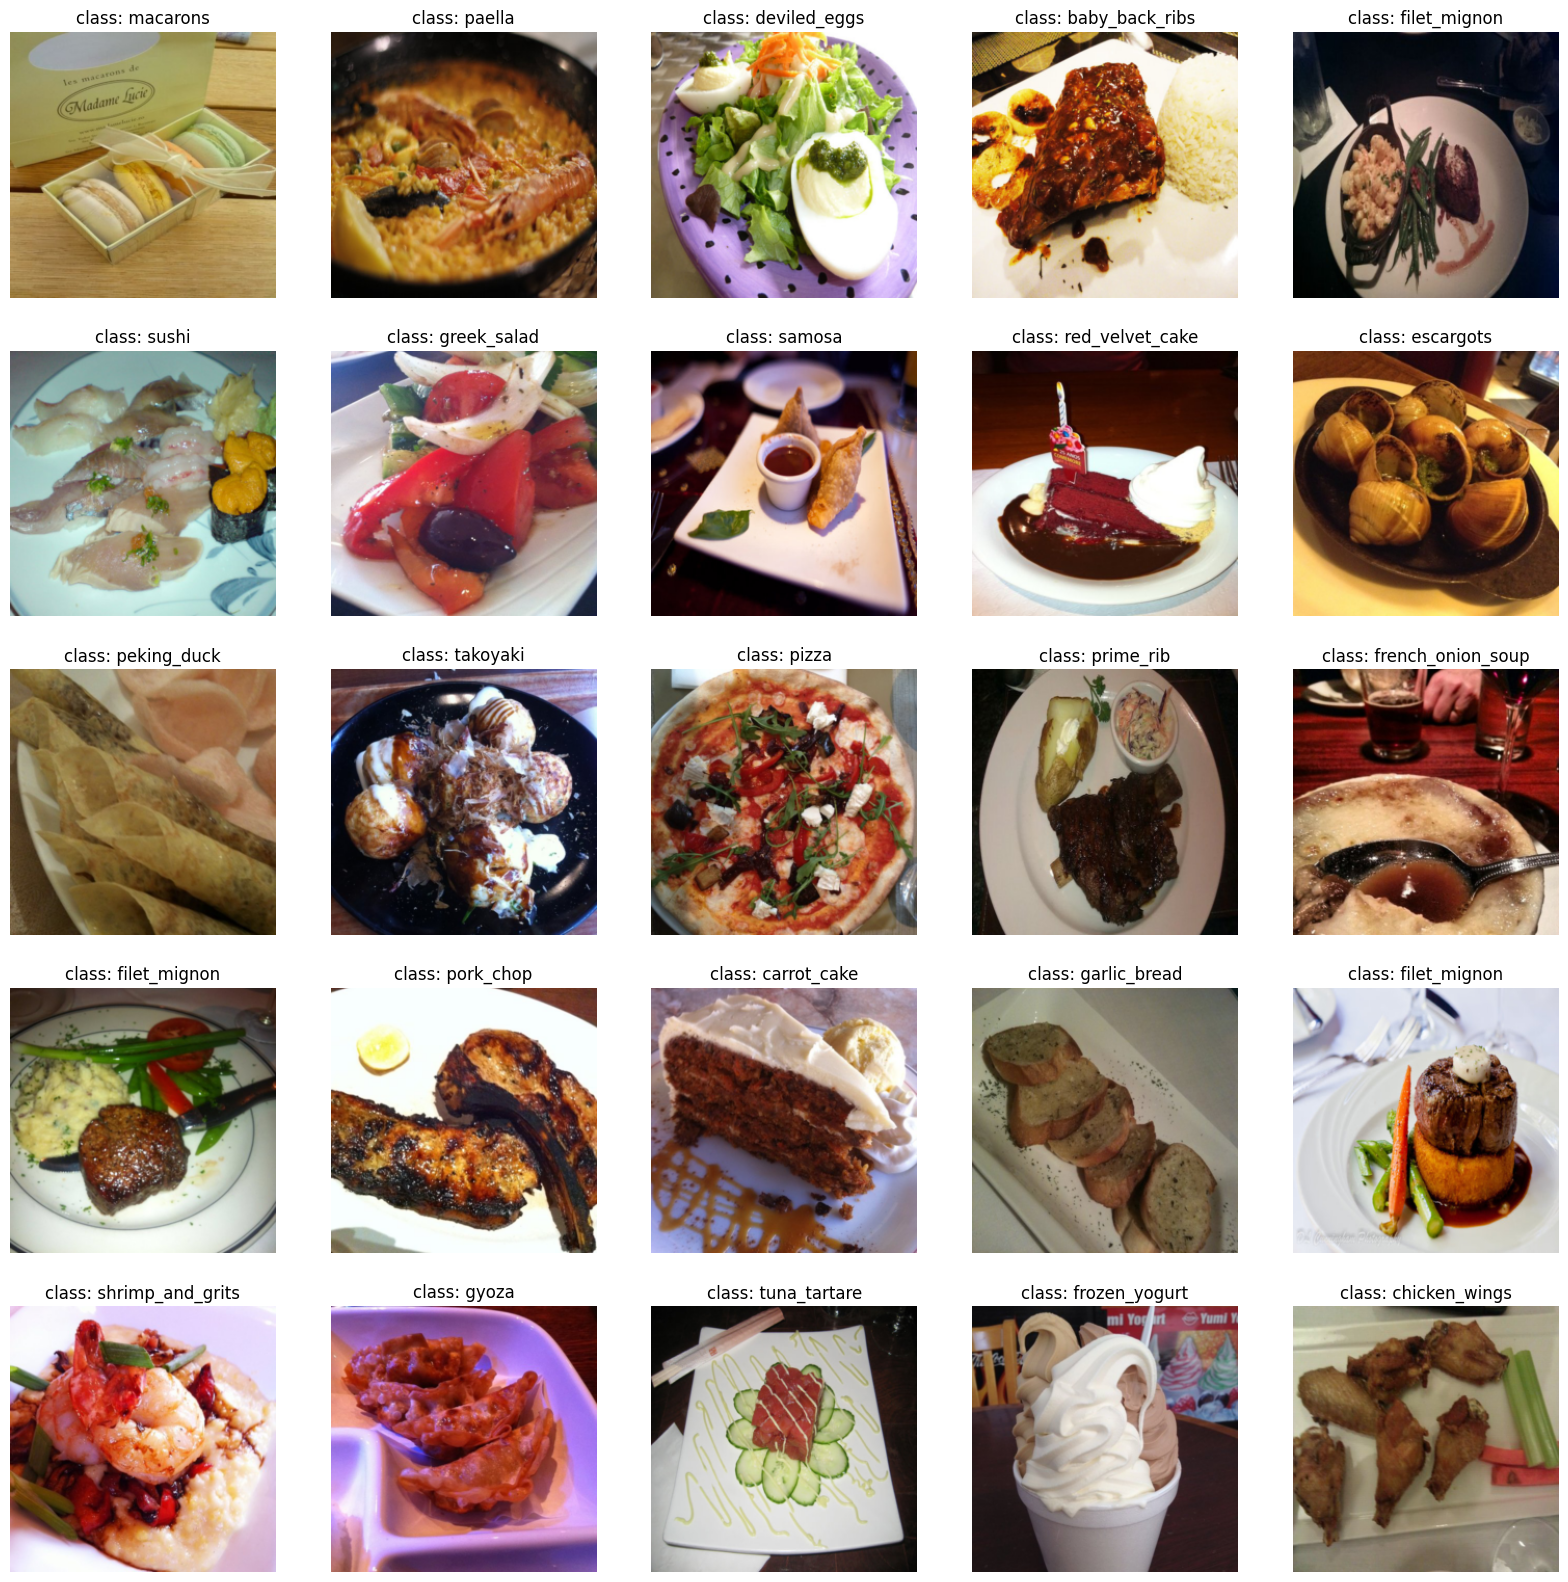

In [3]:
# Display images
manual_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomCrop((256, 256)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_data = datasets.ImageFolder(TRAIN_DIR, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=train_data.classes,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 5. Default PyTorch's Swin Small Transformer

In [4]:
# Create transforms
IMG_SIZE_1 = 384
IMG_SIZE_2 = 384
manual_transforms_train = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((IMG_SIZE_1, IMG_SIZE_1)),
    v2.RandomCrop((IMG_SIZE_2, IMG_SIZE_2)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
    ])

manual_transforms_test = v2.Compose([    
    v2.Resize((IMG_SIZE_1, IMG_SIZE_1)),
    v2.CenterCrop((IMG_SIZE_2, IMG_SIZE_2)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
    ])

# Create dataloaders
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = create_dataloaders(    
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=manual_transforms_train,
    test_transform=manual_transforms_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

# Copy weights from torchvision.models
set_seeds(SEED)

# Instantiate the model
model = create_model('deit_base_patch16_384', pretrained=True)

# Ensure all layers are trainable
for param in model.parameters():
    param.requires_grad = True

model.head = nn.Linear(in_features=model.head.in_features, out_features=len(class_names)).to(device)

# Compile model
model = torch.compile(model, backend="aot_eager")

# Print summary
summary(model,
        input_size=(BATCH_SIZE,3,IMG_SIZE_2, IMG_SIZE_2), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
W0119 13:07:39.329000 30104 site-packages\torch\_dynamo\convert_frame.py:844] [13/8] torch._dynamo hit config.cache_size_limit (8)
W0119 13:07:39.329000 30104 site-packages\torch\_dynamo\convert_frame.py:844] [13/8]    function: 'torch_dynamo_resume_in_forward_at_88' (c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\timm\models\vision_transformer.py:88)
W0119 13:07:39.329000 30104 site-packages\torch\_d

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
OptimizedModule (OptimizedModule)             [32, 3, 384, 384]    [32, 101]            --                   True
├─VisionTransformer (_orig_mod)               [32, 3, 384, 384]    [32, 101]            443,904              True
│    └─PatchEmbed (patch_embed)               [32, 3, 384, 384]    [32, 576, 768]       --                   True
│    │    └─Conv2d (proj)                     [32, 3, 384, 384]    [32, 768, 24, 24]    590,592              True
│    │    └─Identity (norm)                   [32, 576, 768]       [32, 576, 768]       --                   --
│    └─Dropout (pos_drop)                     [32, 577, 768]       [32, 577, 768]       --                   --
│    └─Identity (patch_drop)                  [32, 577, 768]       [32, 577, 768]       --                   --
│    └─Identity (norm_pre)                    [32, 577, 768]       [32, 577, 768]       -

Epoch: 10 | train_loss: 0.8366 | train_acc: 0.9869 | fpr_at_recall: 0.0000 | train_time: 14m43s | test_loss: 1.0539 | test_acc: 0.9165 | fpr_at_recall: 0.0030 | test_time: 2m22s | lr: 0.0000034227


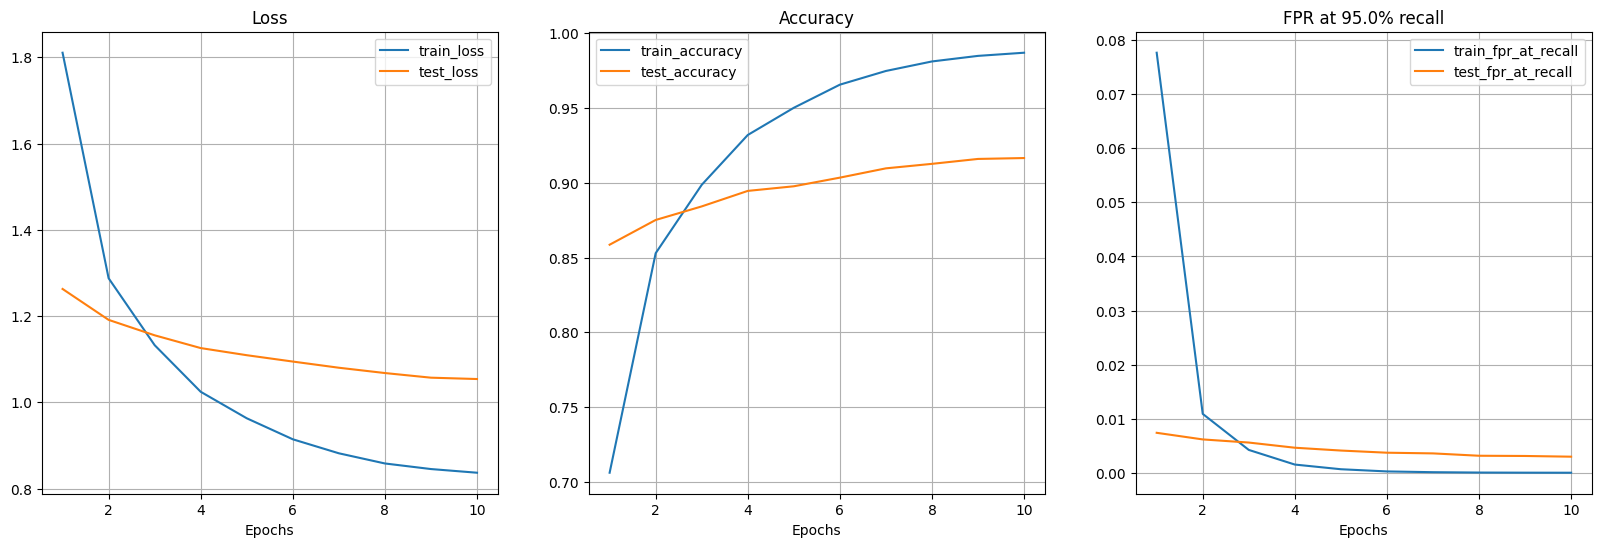

[INFO] Saving model to: ..\models\deitb_101_2025-01-18_loss.pth
[INFO] Saving model to: ..\models\deitb_101_2025-01-18_acc.pth
[INFO] Saving model to: ..\models\deitb_101_2025-01-18.pth


In [5]:
# Train the model
model_type="deitb_101_2025-01-18"
EPOCHS = 10
LR = 0.0001
model_name = f"{model_type}"
model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=model,
    save_best_model=True,
    mode=["loss", "acc"], # Based on accuracy
    device=device)

results = train.fit(
    target_dir=MODEL_DIR,
    model_name=model_name,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=4,
    )

In [6]:
results

epoch  train_loss  train_acc  train_fpr_at_recall  train_time [s]  \
0      1    1.810629   0.706116             0.077648      913.493783   
1      2    1.287593   0.852904             0.010894      891.304278   
2      3    1.132380   0.898614             0.004233      885.572926   
3      4    1.024294   0.931939             0.001527      882.390468   
4      5    0.962849   0.950132             0.000663      884.407527   
5      6    0.914127   0.965589             0.000258      881.324504   
6      7    0.881646   0.974749             0.000117      892.890490   
7      8    0.858051   0.981111             0.000050      880.711698   
8      9    0.845102   0.984834             0.000029      880.900383   
9     10    0.836596   0.986946             0.000019      883.811632   

   test_loss  test_acc  test_fpr_at_recall  test_time [s]        lr  
0   1.262765  0.858573            0.007397     158.264264  0.000100  
1   1.191069  0.875119            0.006173     146.565670  0.000098  
2   1.155277  0.884183            0.005595     141.970770  0.000091  
3   1.125665  0.894554            0.004639     142.356954  0.000080  
4   1.109127  0.897641            0.004118     143.865061  0.000066  
5   1.094392  0.903420            0.003718     142.767300  0.000051  
6   1.080075  0.909634            0.003591     143.176946  0.000035  
7   1.067767  0.912642            0.003156     141.518257  0.000021  
8   1.057006  0.915928            0.003114     143.618646  0.000010  
9   1.053892  0.916522            0.002983     142.740396  0.000003

Epoch: 20 | train_loss: 0.8111 | train_acc: 0.9921 | fpr_at_recall: 0.0000 | train_time: 14m5s | test_loss: 1.0533 | test_acc: 0.9199 | fpr_at_recall: 0.0034 | test_time: 2m27s | lr: 0.0000016094


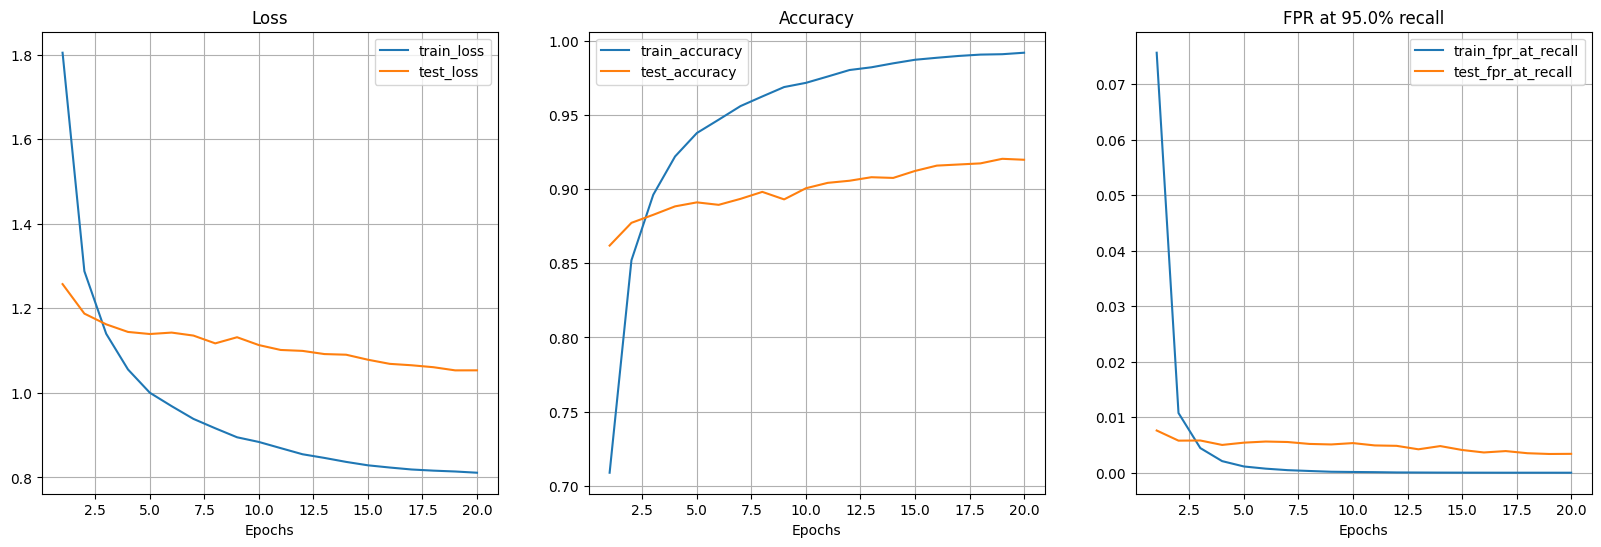

[INFO] Saving model to: ..\models\deitb_101_2025-01-19.pth


In [5]:
# Train the model
model_type="deitb_101_2025-01-19"
EPOCHS = 20
LR = 0.0001
model_name = f"{model_type}"
model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=model,
    save_best_model=True,
    mode=["loss", "acc"], # Based on accuracy
    device=device)

results = train.fit(
    target_dir=MODEL_DIR,
    model_name=model_name,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=2,
    )

In [6]:
results

epoch  train_loss  train_acc  train_fpr_at_recall  train_time [s]  \
0       1    1.804740   0.708694             0.075644      867.380608   
1       2    1.287846   0.852024             0.010756      844.515673   
2       3    1.139866   0.896229             0.004445      846.523352   
3       4    1.055348   0.922077             0.002093      849.790367   
4       5    1.000353   0.937892             0.001129      848.485643   
5       6    0.968598   0.946896             0.000737      835.467930   
6       7    0.938437   0.956059             0.000467      832.020000   
7       8    0.916227   0.962561             0.000318      830.266542   
8       9    0.894938   0.968908             0.000180      839.273028   
9      10    0.883877   0.971746             0.000139      850.536892   
10     11    0.869279   0.976021             0.000105      846.509825   
11     12    0.854800   0.980403             0.000054      846.198312   
12     13    0.846163   0.982233             0.000039      842.173864   
13     14    0.836711   0.984916             0.000025      839.381104   
14     15    0.828620   0.987318             0.000017      839.508869   
15     16    0.823380   0.988664             0.000013      844.290370   
16     17    0.818733   0.989891             0.000008      845.657794   
17     18    0.816024   0.990802             0.000009      843.459362   
18     19    0.814001   0.991066             0.000007      846.075198   
19     20    0.811094   0.992069             0.000005      845.171195   

    test_loss  test_acc  test_fpr_at_recall  test_time [s]        lr  
0    1.257325  0.861946            0.007609     151.816605  0.000100  
1    1.187520  0.877294            0.005782     145.526288  0.000099  
2    1.162143  0.882714            0.005808     143.718296  0.000098  
3    1.144164  0.888410            0.005010     143.276589  0.000095  
4    1.139249  0.891100            0.005420     143.089799  0.000091  
5    1.142634  0.889438            0.005623     140.185214  0.000086  
6    1.135548  0.893473            0.005536     139.028681  0.000080  
7    1.117119  0.898180            0.005191     139.302956  0.000073  
8    1.131620  0.893117            0.005096     145.515619  0.000066  
9    1.113053  0.900633            0.005339     144.897123  0.000058  
10   1.101516  0.904272            0.004919     141.713227  0.000051  
11   1.099344  0.905696            0.004847     140.882671  0.000043  
12   1.091833  0.908070            0.004222     141.331826  0.000035  
13   1.090290  0.907595            0.004804     141.159150  0.000028  
14   1.078434  0.912302            0.004101     145.752413  0.000021  
15   1.068658  0.915902            0.003653     141.095722  0.000015  
16   1.065322  0.916653            0.003902     143.780813  0.000010  
17   1.060731  0.917405            0.003516     141.246775  0.000006  
18   1.053248  0.920491            0.003380     140.836176  0.000003  
19   1.053314  0.919858            0.003405     147.320719  0.000002

In [7]:
training_time = sec_to_min_sec(results["train_time [s]"].mean() + results["test_time [s]"].mean())
print(f"training time: {training_time}")

training time: 16m27s
